Assignment 10 Supplementary: Semantic Search Demo
===============

This Python notebook guides you through the code for Text-to-Image and Image-to-Image search.

Prior to starting, you should have a file called `image_embeddings.pickle` and a file called `coco_images_resized.zip` in the current directory.

First, unzip `coco_images_resized.zip`. This directory contains the images that you will search through.

This assignment uses pretrained CLIP (Contrastive Language Image Pretrained) models to embed text and images into a joint embedding space. You can read about CLIP models here: https://www.pinecone.io/learn/clip-image-search/

**Your end goal is to find the most relevant images given either an image or a text query.**

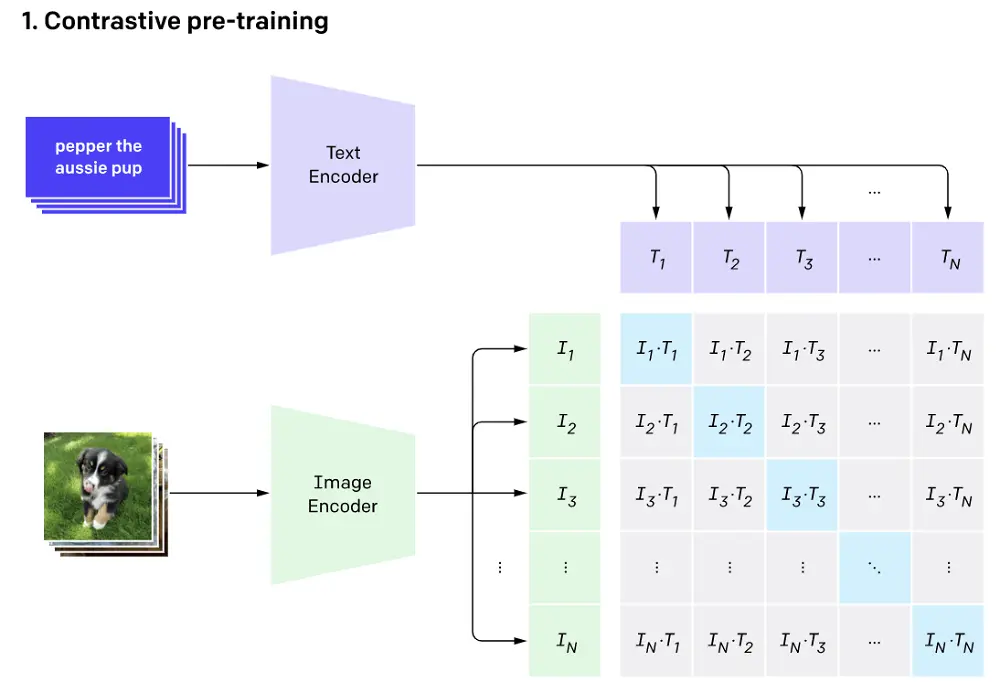

### Step 1: Caclulate Image Embeddings for Dataset

We first want to make our image database easily searchable. To achieve this, we calculate the image embedding for each image using the image encoder. **This has already been done for you,** because it is computationally intensive. Below is the code for reference.

In [43]:
# import os
# import torch
# import torchvision.transforms as transforms
# from PIL import Image
# from open_clip import create_model_and_transforms, tokenizer
# import torch.nn.functional as F
# import pandas as pd
# from tqdm import tqdm

# # Configuration
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model_name = "ViT-B/32"
# pretrained = "openai"
# batch_size = 128
# image_folder = "/scratch/cliao25/train2014/train2014"  # Replace with your folder path

# # Load the model and preprocess function
# model, preprocess_train, preprocess_val = create_model_and_transforms(model_name, pretrained=pretrained)
# model = model.to(device)
# model.eval()

# # Image transformations (using preprocess_val from open_clip)
# transform = preprocess_val

# # Collect all image paths
# image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]
# print('Number of images:', len(image_paths))
# # DataFrame to store results
# results = []

# # Function to load and preprocess images
# def load_images(batch_paths):
#     images = []
#     for path in batch_paths:
#         try:
#             image = Image.open(path).convert("RGB")
#             images.append(transform(image))
#         except Exception as e:
#             print(f"Error loading image {path}: {e}")
#     return torch.stack(images) if images else None

# # Process images in batches
# with torch.no_grad():
#     for i in tqdm(range(0, len(image_paths), batch_size), desc="Processing images"):
#         batch_paths = image_paths[i:i + batch_size]
#         images = load_images(batch_paths)
#         if images is None:  # Skip if no valid images in this batch
#             continue

#         images = images.to(device)
#         embeddings = model.encode_image(images)
#         embeddings = F.normalize(embeddings, p=2, dim=1)  # Normalize the embeddings

#         for path, emb in zip(batch_paths, embeddings):
#             results.append({"file_name": os.path.basename(path), "embedding": emb.cpu().numpy()})

# Save results to a DataFrame
# df = pd.DataFrame(results)
# df.to_pickle('image_embeddings.pickle')

Run the code below to examine the dataframe.

The dataframe `df` has two columns. The first column is the image file in the dataset folder. The second column is the image embedding corresponding to that image.

In [44]:
import pandas as pd

df = pd.read_pickle('image_embeddings.pickle')
print(df.head())

                         file_name  \
0  COCO_train2014_000000017154.jpg   
1  COCO_train2014_000000356738.jpg   
2  COCO_train2014_000000124428.jpg   
3  COCO_train2014_000000277426.jpg   
4  COCO_train2014_000000474616.jpg   

                                           embedding  
0  [-0.013383481, 0.025817081, 0.027312446, 0.029...  
1  [-0.018858824, 0.066932686, -0.023063071, -0.0...  
2  [0.034829315, -0.014156876, -0.0095499605, 0.0...  
3  [-0.00678755, -0.04286685, 0.0022111333, -0.02...  
4  [0.017978659, 0.002254282, -0.00318466, 0.0169...  


### Step 2: Image-to-Image Search

Now you will write some code to find the closest image in the dataset to a given image query.

Find a random image off the internet. Use the CLIP image encoder to encode the image; let's call this the `query_embedding`.

Now, display the image in the dataset that has the **maximum cosine similarity with the query embedding.**

**It is very important that you use the `ViT-B/32, openai` version of the CLIP model** to be consistent with the embeddings you were given.

Here's the documentation for CLIP: https://github.com/mlfoundations/open_clip

**Hint:** Take advantage of the code given to you at the bedginning of this assignment.

In [45]:
! pip install open-clip-torch


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


This is my query image


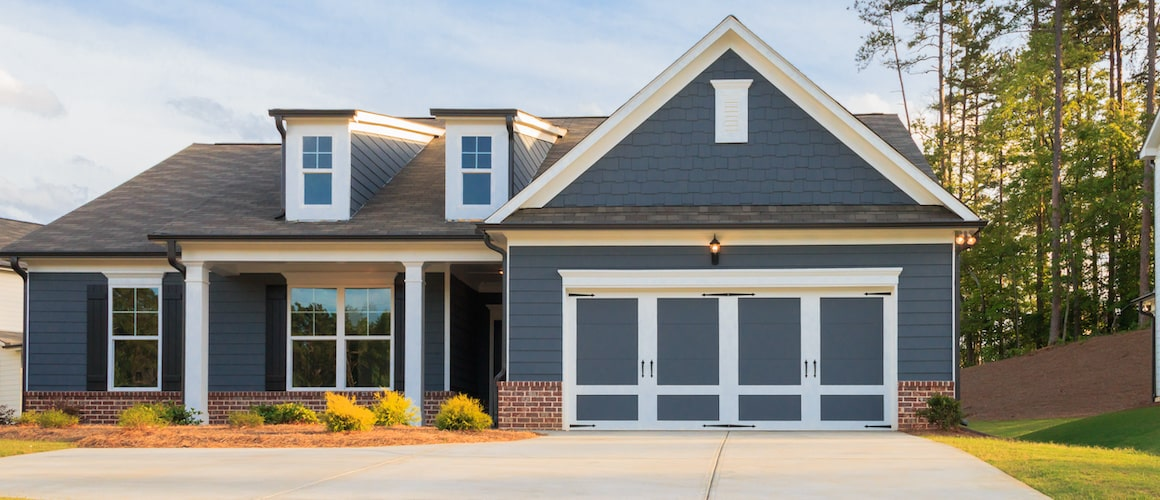

In [46]:
from IPython.display import Image
print('This is my query image')
Image(filename="house.jpg")

In [47]:
from PIL import Image
from open_clip import create_model_and_transforms, tokenizer
import torch.nn.functional as F

model, _, preprocess = create_model_and_transforms('ViT-B/32', pretrained='openai')

# This converts the image to a tensor
image = preprocess(Image.open("house.jpg")).unsqueeze(0)

# This calculates the query embedding
query_embedding = F.normalize(model.encode_image(image))

In [48]:
# Retrieve the image path that corresponds to the embedding in `df`
# with the highest cosine similarity to `query_embedding`
import pandas as pd
import torch

# Load precomputed embeddings
df = pd.read_pickle("image_embeddings.pickle")

# Calculate cosine similarity
df['similarity'] = torch.matmul(
    torch.tensor(query_embedding),
    torch.tensor(df['embedding'].tolist()).T
).squeeze()

# Sort by similarity and get the most similar image
results = df.sort_values(by='similarity', ascending=False)
most_similar_image = results.iloc[0]['file_name']
impath = f'coco_images_resized/{most_similar_image}'

/var/folders/j5/_m1838mj4zq2_9w7_j7k9w8w0000gn/T/ipykernel_23031/3644201211.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(query_embedding),


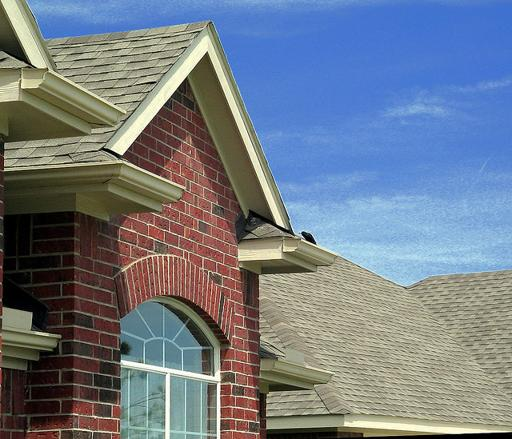

In [49]:
from IPython.display import Image
Image(filename=impath)

### Step 3: Text-to-Image Search

Now implement text-to-image-search.

The only difference here is that the query is a string of text. You will use the text encoder to obtain the corresponding query embedding.

<module 'open_clip.tokenizer' from '/Users/tiffanychen/Documents/FALL2024/CS506/GitHub/qtc-assignment-10/venv/lib/python3.12/site-packages/open_clip/tokenizer.py'>
Query Embedding Shape: torch.Size([1, 512])
Similarity: 0.31682148575782776


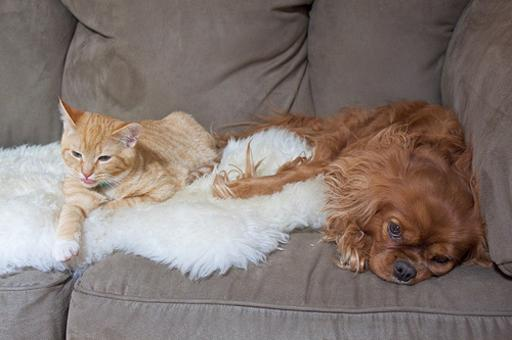

Similarity: 0.3157406747341156


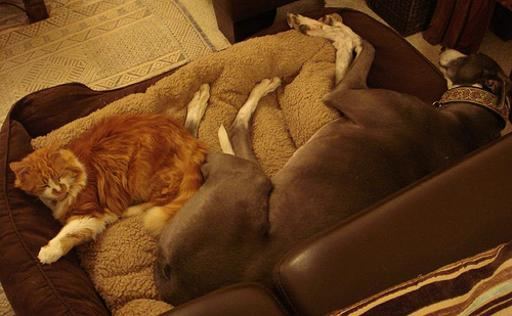

Similarity: 0.3087063133716583


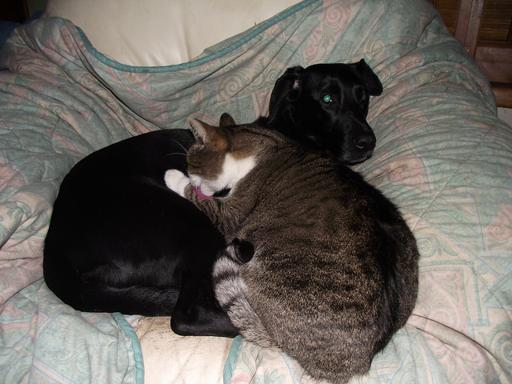

Similarity: 0.3079783022403717


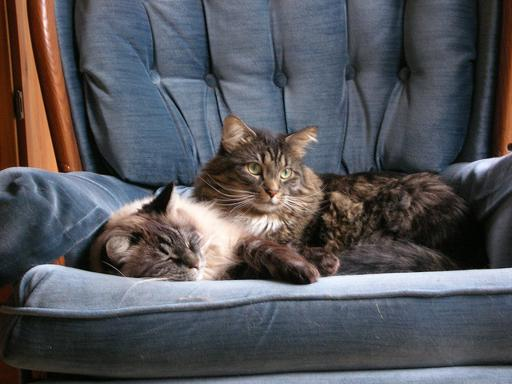

Similarity: 0.30320921540260315


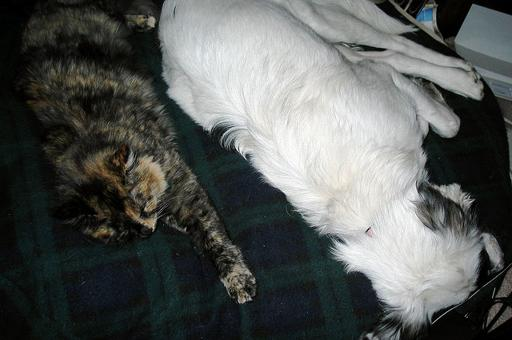

In [ ]:
import pandas as pd
import torch
from open_clip import create_model_and_transforms, tokenizer
import torch.nn.functional as F

# Debugging: Print tokenizer to understand its type
print(tokenizer)

# Load precomputed embeddings
df = pd.read_pickle('image_embeddings.pickle')

# Load the model and preprocessing transforms
model, _, preprocess = create_model_and_transforms('ViT-B/32', pretrained='openai')
model.eval()  # Set the model to evaluation mode

# Define the text query
text_query = ["cat cuddles with dog on sofa."]

# Use the `tokenize` method from the `tokenizer` module
tokens = tokenizer.tokenize(text_query)

# Generate query embedding for the text query
query_embedding = F.normalize(model.encode_text(tokens))

# Debug: Check query embedding
print("Query Embedding Shape:", query_embedding.shape)

# Calculate cosine similarity
similarities = []
for emb in df['embedding']:
    emb_tensor = torch.tensor(emb).unsqueeze(0)  # Convert to tensor
    similarity = torch.nn.functional.cosine_similarity(query_embedding, emb_tensor).item()
    similarities.append(similarity)

# Add similarities to the DataFrame
df['similarity'] = similarities

# Retrieve the top result
top_results = df.sort_values(by='similarity', ascending=False).head(5)

# Display the most similar image
from IPython.display import Image, display
for _, row in top_results.iterrows():
    impath = f"coco_images_resized/{row['file_name']}"
    print(f"Similarity: {row['similarity']}")
    display(Image(filename=impath))


### Step 4:  Hybrid Query

A more interesting query could contain both image and text.

For example, instead of explicitly searching for an "image of snowy house", you could search for "snowy" + an image of a house.


In this case, you should embed both the text query and the image query. Then, the query embedding is a weighted average of the two embeddings.

Similarity: 0.3889727294445038


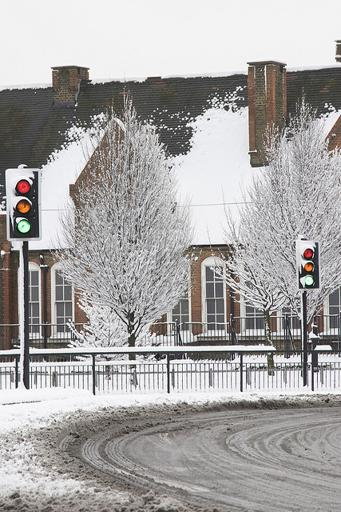

Similarity: 0.38018858432769775


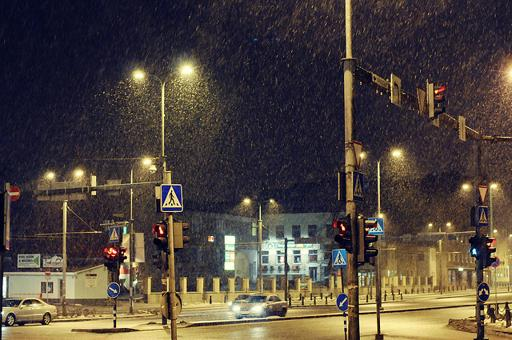

Similarity: 0.37792208790779114


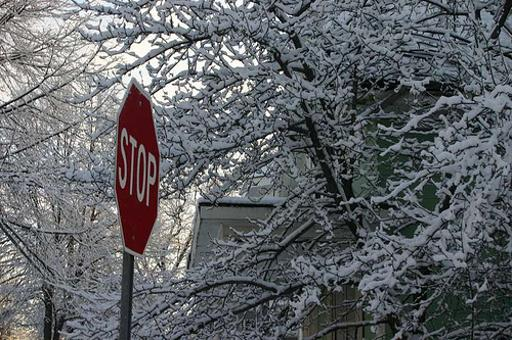

Similarity: 0.37503933906555176


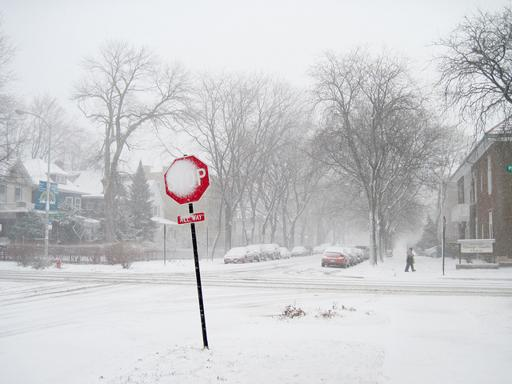

Similarity: 0.3741481304168701


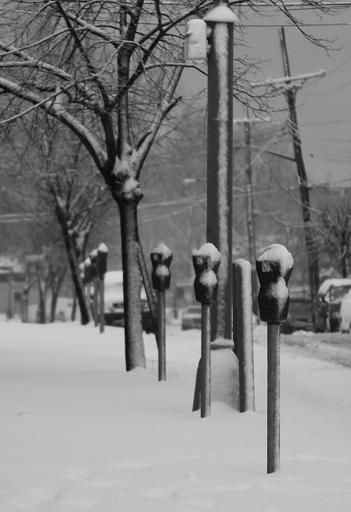

In [ ]:
import pandas as pd
import torch
from open_clip import create_model_and_transforms, tokenizer
import torch.nn.functional as F
from PIL import Image
from IPython.display import Image as IPImage, display

# Load the CLIP model and tokenizer
model, _, preprocess = create_model_and_transforms('ViT-B/32', pretrained='openai')
model.eval()  # Set the model to evaluation mode

# Use the tokenizer available in open_clip
tokenizer = tokenizer

# Load precomputed image embeddings
df = pd.read_pickle('image_embeddings.pickle')

# Encode the image query
image = preprocess(Image.open("house.jpg")).unsqueeze(0)  # Example image
image_query = F.normalize(model.encode_image(image))  # Normalize the image embedding

# Encode the text query
text_query = F.normalize(model.encode_text(tokenizer.tokenize(["snowy"])))  # Example text query

# Combine text and image embeddings (hybrid query)
lam = 0.8  # Weight for text query
hybrid_query = F.normalize(lam * text_query + (1.0 - lam) * image_query)  # Weighted combination

# Compute cosine similarity
similarities = []
for emb in df['embedding']:
    emb_tensor = torch.tensor(emb).unsqueeze(0)  # Convert to tensor
    similarity = torch.nn.functional.cosine_similarity(hybrid_query, emb_tensor).item()
    similarities.append(similarity)

# Add similarities to the DataFrame
df['similarity'] = similarities

# Retrieve top 5 results
top_results = df.sort_values(by='similarity', ascending=False).head(5)

# Display the top results
for _, row in top_results.iterrows():
    impath = f"coco_images_resized/{row['file_name']}"  # Construct image path
    print(f"Similarity: {row['similarity']}")
    display(IPImage(filename=impath))  # Display the image